In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 1

In [3]:
%aimport activations

In [4]:
mnist = fetch_mldata('MNIST original')

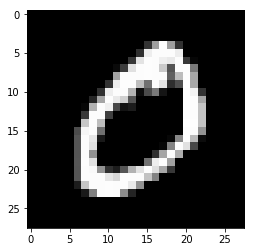

In [5]:
plt.imshow(mnist.data[0].reshape(28, 28), cmap='gray')
plt.show()